/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


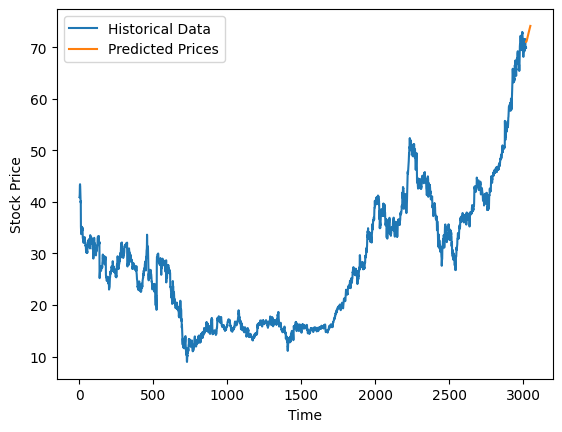

In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import matplotlib.pyplot as plt

# Load and preprocess data
data = pd.read_csv('/content/drive/MyDrive/stock_data.csv')['Close'].values.reshape(-1, 1)
scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(data)

# Prepare training data
lookback = 60  # Number of previous days to use for prediction
X, y = [], []
for i in range(lookback, len(data_scaled)):
    X.append(data_scaled[i - lookback:i, 0])
    y.append(data_scaled[i, 0])
X, y = np.array(X), np.array(y)
X = np.reshape(X, (X.shape[0], X.shape[1], 1))  # Reshape for LSTM input

# Build LSTM model
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(X.shape[1], 1)),
    LSTM(50),
    Dense(1)
])
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X, y, epochs=10, batch_size=32, verbose=0)

# Predict future prices
test_data = data_scaled[-lookback:]
predicted_prices = []
for _ in range(30):  # Predicting for 30 days into the future
    x_test = test_data[-lookback:].reshape(1, lookback, 1)
    prediction = model.predict(x_test, verbose=0)
    predicted_prices.append(prediction[0, 0])
    test_data = np.append(test_data, prediction, axis=0)

predicted_prices = scaler.inverse_transform(np.array(predicted_prices).reshape(-1, 1))

# Plot results
plt.plot(data, label='Historical Data')
plt.plot(range(len(data), len(data) + len(predicted_prices)), predicted_prices, label='Predicted Prices')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step
Mean Absolute Error (MAE): 1.125418671487971
Root Mean Squared Error (RMSE): 1.4847241393782513


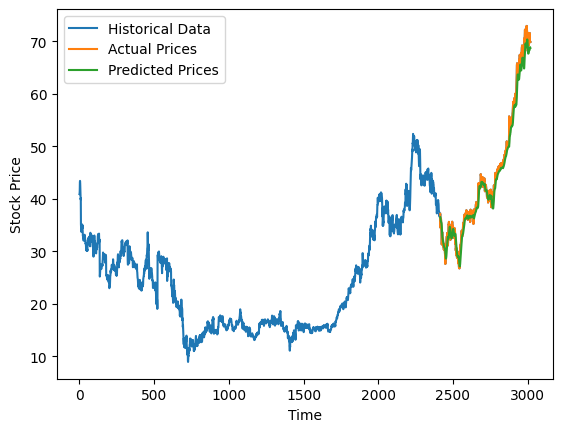

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Split data into training and testing sets
train_size = int(len(data_scaled) * 0.8)
train_data = data_scaled[:train_size]
test_data = data_scaled[train_size - lookback:]

# Prepare training data
X_train, y_train = [], []
for i in range(lookback, len(train_data)):
    X_train.append(train_data[i - lookback:i, 0])
    y_train.append(train_data[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

# Prepare test data
X_test, y_test = [], []
for i in range(lookback, len(test_data)):
    X_test.append(test_data[i - lookback:i, 0])
    y_test.append(test_data[i, 0])
X_test, y_test = np.array(X_test), np.array(y_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# Build and train the model
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], 1)),
    LSTM(50),
    Dense(1)
])
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, epochs=10, batch_size=32, verbose=0)

# Predict on test data
predicted_test_prices = model.predict(X_test)
predicted_test_prices = scaler.inverse_transform(predicted_test_prices)
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))

# Calculate accuracy metrics
mae = mean_absolute_error(y_test_actual, predicted_test_prices)
rmse = np.sqrt(mean_squared_error(y_test_actual, predicted_test_prices))

print(f"Mean Absolute Error (MAE): {mae}")
print(f"Root Mean Squared Error (RMSE): {rmse}")

# Plot results
plt.plot(data, label='Historical Data')
plt.plot(range(len(data) - len(y_test_actual), len(data)), y_test_actual, label='Actual Prices')
plt.plot(range(len(data) - len(predicted_test_prices), len(data)), predicted_test_prices, label='Predicted Prices')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()
